Implement basic neural networks from scratch using NumPy and then using PyTorch.

# **Understanding Neural Networks**
A neural network is an extension of generalized linear models, enhanced with non-linear activation functions. This allows the model to learn intricate patterns in the data, making it well-suited for complex classification tasks.

# **Objective:**
Predict the probability of class y given the inputs X. Non-linearity is introduced to model the complex, non-linear data.

# **Set up**
We'll set our seeds for reproducibility.

In [ ]:
import numpy as np
import random
SEED = 1234
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

# **Load Data**
Generate a Spiral Dataset Locally
You can generate a non-linearly separable spiral dataset using sklearn.datasets.make_classification and numpy. Here's a script to create and save the dataset:

         X1        X2  color
0  0.000000  0.000000      0
1 -0.000074  0.002003      0
2  0.000929  0.003899      0
3  0.001349  0.005859      0
4  0.002037  0.007753      0


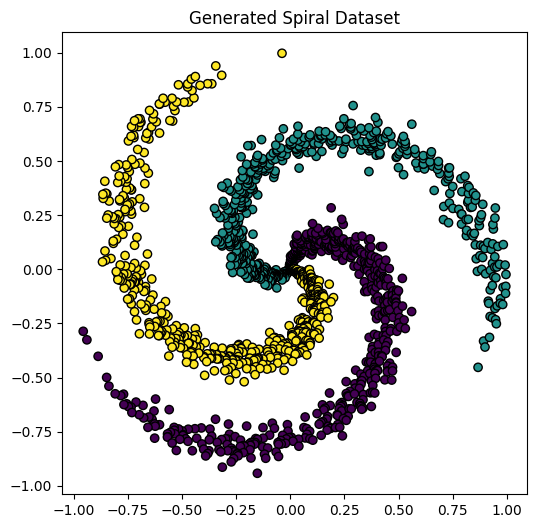

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate spiral dataset
def generate_spiral(n_samples, n_classes):
    X = []
    y = []
    for i in range(n_classes):
        ix = range(n_samples // n_classes * i, n_samples // n_classes * (i + 1))
        r = np.linspace(0.0, 1, n_samples // n_classes)  # radius
        t = np.linspace(i * 4, (i + 1) * 4, n_samples // n_classes) + np.random.randn(n_samples // n_classes) * 0.2  # theta
        X.append(np.c_[r * np.sin(t), r * np.cos(t)])
        y.append(np.full(n_samples // n_classes, i))
    return np.vstack(X), np.hstack(y)

# Generate dataset
n_samples = 1500
n_classes = 3
X, y = generate_spiral(n_samples, n_classes)

# Convert to DataFrame
df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "color": y})

# Save to CSV
df.to_csv("spiral.csv", index=False)

# Load and preview data
df = pd.read_csv("spiral.csv")
print(df.head())

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(df["X1"], df["X2"], c=df["color"], cmap="viridis", edgecolors="k")
plt.title("Generated Spiral Dataset")
plt.show()


# **Split data**
We'll shuffle our dataset (since it's ordered by class) and then create our data splits (stratified on class).

In [ ]:
import collections
from sklearn.model_selection import train_test_split

# Define split sizes
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Extract features and labels
X = df[["X1", "X2"]].values
y = df["color"].values

# Function to split dataset while maintaining class balance
def train_val_test_split(X, y, train_size):
    """Split dataset into training, validation, and test sets (stratified by class)."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y, random_state=1234)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_, random_state=1234)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, TRAIN_SIZE)

# Print dataset shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.11631401 -0.03761337] → 1


# **Label encoding**
Previously, we implemented our own label encoder to understand how categorical values are converted into numerical representations. Now, we will use scikit-learn's LabelEncoder, which performs the same operation efficiently.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on training labels
label_encoder.fit(y_train)

# Retrieve class labels
classes = list(label_encoder.classes_)
print(f"Classes: {classes}")

Classes: [0, 1, 2]


In [ ]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 1
y_train[0]: 1


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


# **Standardize data**
We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights. We're only going to standardize the inputs X because our outputs y are class values.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

# Check (means should be ~0 and std should be ~1)
print(f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print(f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: -0.0, std: 1.0
X_test[1]: mean: 0.2, std: 1.0


Linear model
Before we get to our neural network, we're going to motivate non-linear activation functions by implementing a generalized linear model (logistic regression). We'll see why linear models (with linear activations) won't suffice for our dataset.

In [ ]:
import torch
# Set seed for reproducibility
torch.manual_seed(SEED)

# **Model**
We'll create our linear model using one layer of weights.

In [ ]:
from torch import nn
import torch.nn.functional as F

# Define model parameters
INPUT_DIM = X_train.shape[1]  # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes)  # 3 classes

# Define Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)  # Linear activation
        z = self.fc2(z)
        return z

# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print(model.named_parameters)


<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# **Training**
We'll go ahead and train our initialized model for a few epochs.



In [ ]:
from torch.optim import Adam

# Hyperparameters
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

# Define Loss Function with Class Weights
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Accuracy Function
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

# Training Loop
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Compute Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Print metrics every epoch
    if epoch % 1 == 0:
        predictions = y_pred.max(dim=1)[1]  # Get class predictions
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {accuracy:.1f}")


Epoch: 0 | Loss: 1.30, Accuracy: 15.9
Epoch: 1 | Loss: 1.00, Accuracy: 53.7
Epoch: 2 | Loss: 0.84, Accuracy: 55.5
Epoch: 3 | Loss: 0.77, Accuracy: 53.2
Epoch: 4 | Loss: 0.75, Accuracy: 52.3
Epoch: 5 | Loss: 0.76, Accuracy: 51.9
Epoch: 6 | Loss: 0.77, Accuracy: 52.0
Epoch: 7 | Loss: 0.78, Accuracy: 51.6
Epoch: 8 | Loss: 0.79, Accuracy: 52.0
Epoch: 9 | Loss: 0.79, Accuracy: 52.2


# **Evaluation**
Now let's see how well our linear model does on our non-linear spiral data.

In [ ]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance dictionary
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

# Predictions
y_prob = F.softmax(model(X_test), dim=1)
print(f"Sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print(f"Sample class: {y_pred[0]}")


Sample probability: tensor([0.3032, 0.0040, 0.6928], grad_fn=<SelectBackward0>)
Sample class: 2


In [ ]:

from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance dictionary
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = float(metrics[0])
    performance["overall"]["recall"] = float(metrics[1])
    performance["overall"]["f1"] = float(metrics[2])
    performance["overall"]["num_samples"] = int(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][str(classes[i])] = {  # Convert class labels to str
            "precision": float(metrics[0][i]),
            "recall": float(metrics[1][i]),
            "f1": float(metrics[2][i]),
            "num_samples": int(metrics[3][i]),  # Convert NumPy int64 to int
        }

    return performance

# Evaluate model performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)

# Print performance metrics in JSON format
print(json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.5468667687292711,
    "recall": 0.5466666666666666,
    "f1": 0.5428697334891652,
    "num_samples": 225
  },
  "class": {
    "0": {
      "precision": 0.559322033898305,
      "recall": 0.44,
      "f1": 0.4925373134328358,
      "num_samples": 75
    },
    "1": {
      "precision": 0.5617977528089888,
      "recall": 0.6666666666666666,
      "f1": 0.6097560975609756,
      "num_samples": 75
    },
    "2": {
      "precision": 0.5194805194805194,
      "recall": 0.5333333333333333,
      "f1": 0.5263157894736842,
      "num_samples": 75
    }
  }
}


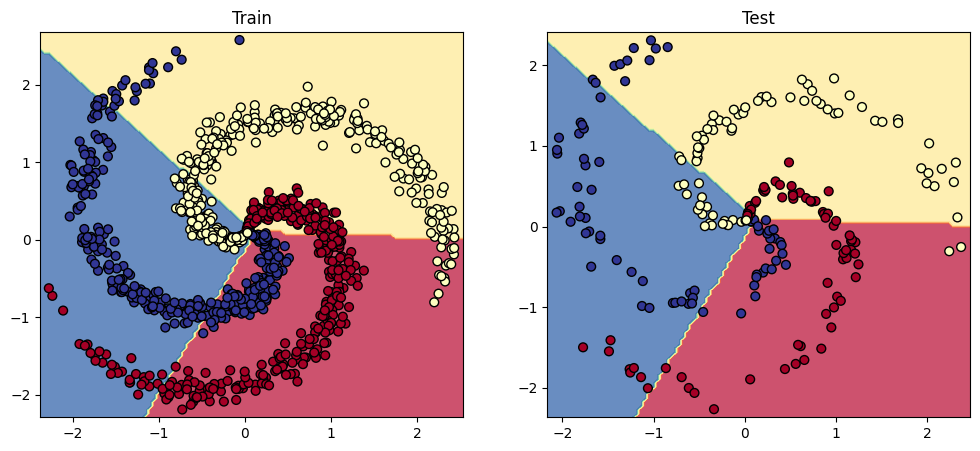

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def plot_multiclass_decision_boundary(model, X, y):
    """Plots the decision boundary for a multi-class classification model."""
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Convert meshgrid to PyTorch tensor
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

    # Get predictions
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Visualize the decision boundary
plt.figure(figsize=(12, 5))

# Training set decision boundary
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train.numpy(), y=y_train.numpy())

# Test set decision boundary
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test.numpy(), y=y_test.numpy())

plt.show()


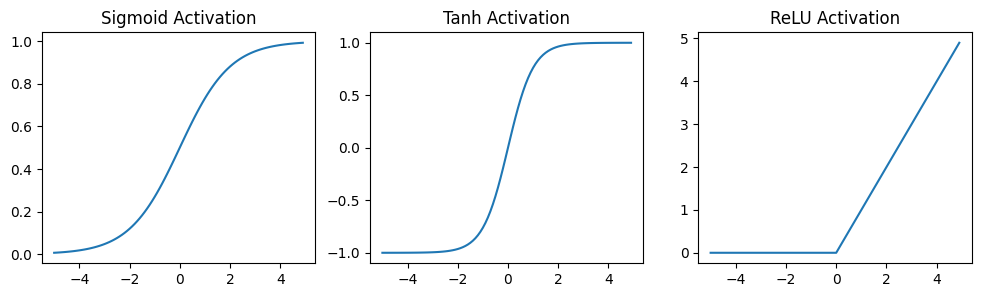

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Fig size
plt.figure(figsize=(12, 3))

# Data range for activation functions
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrains values between 0 and 1)
plt.subplot(1, 3, 1)
plt.title("Sigmoid Activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrains values between -1 and 1)
plt.subplot(1, 3, 2)
plt.title("Tanh Activation")
y = torch.tanh(x)
plt.plot(x.numpy(), y.numpy())

# ReLU activation (clips negative values to 0)
plt.subplot(1, 3, 3)
plt.title("ReLU Activation")
y = F.relu(x)
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()


The ReLU activation function (*max(0,z)*
) is by far the most widely used activation function for neural networks. But as you can see, each activation function has its own constraints so there are circumstances where you'll want to use different ones. For example, if we need to constrain our outputs between 0 and 1, then the sigmoid activation is the best choice.

# **NumPy**
We will now build a multilayer perceptron (MLP), which closely resembles a logistic regression model but incorporates an activation function to handle the non-linearity in our dataset.

Understanding the mathematical concepts and code in this section may seem challenging at first. However, going through each step will help develop an intuition, making the transition to PyTorch implementation smoother.

Our objective is to develop a model ŷ that predicts y based on X. Essentially, neural networks extend generalized linear models, enhancing them with non-linear activation functions to effectively model complex, non-linear data patterns.

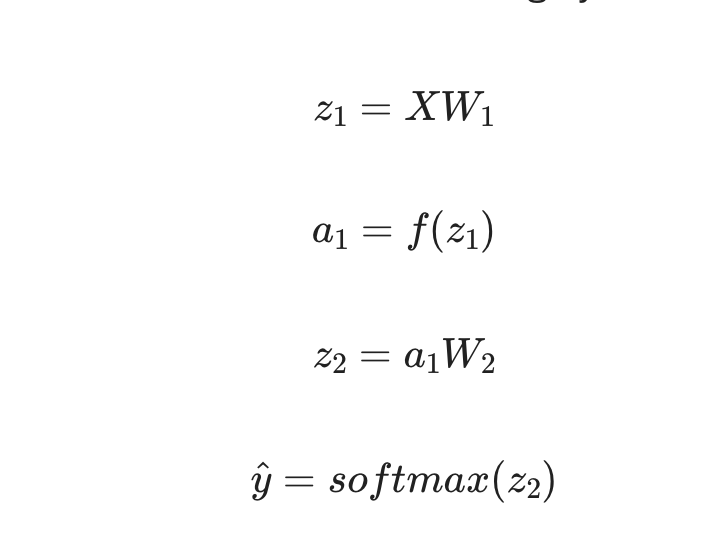

Initialize weights
Step 1: Randomly initialize the model's weights
 (we'll cover more effective initialization strategies later in this lesson).

In [ ]:
# Initialize first layer's weights randomly
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))

# Print weight and bias shapes
print(f"W1 shape: {W1.shape}")
print(f"b1 shape: {b1.shape}")


W1 shape: (2, 100)
b1 shape: (1, 100)


# **Model**
Step 2: Pass the input X into the model to perform a forward pass and generate probability predictions. The process begins by feeding the inputs into the first layer.

In [ ]:
# Compute first layer activations
# z1 = [NX2] · [2X100] + [1X100] = [NX100]
z1 = np.dot(X_train, W1) + b1

# Print shape of z1
print(f"z1 shape: {z1.shape}")


z1 shape: (1050, 100)


Next we apply the non-linear activation function, ReLU *(max(0,z))*
) in this case.
*a1 = f(z1)*


In [ ]:
# Apply activation function
a1 = np.maximum(0, z1) # ReLU
print (f"a_1: {a1.shape}")

a_1: (1050, 100)


In [ ]:
# Initialize second layer's weights
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Print weight and bias shapes
print(f"W2 shape: {W2.shape}")
print(f"b2 shape: {b2.shape}")

# Compute logits (pre-activation values for output layer)
# z2 = logits = [NX100] · [100X3] + [1X3] = [NX3]
logits = np.dot(a1, W2) + b2

# Print shape of logits and a sample value
print(f"logits shape: {logits.shape}")
print(f"sample logits: {logits[0]}")

# Apply softmax to obtain class probabilities
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Print shape of probabilities and a sample
print(f"probabilities shape: {probabilities.shape}")
print(f"sample probabilities: {probabilities[0]}")


W2 shape: (100, 3)
b2 shape: (1, 3)
logits shape: (1050, 3)
sample logits: [-1.94968504e-04  2.08459974e-05 -5.39947646e-04]
probabilities shape: (1050, 3)
sample probabilities: [0.33334768 0.33341963 0.3332327 ]


To normalize the logits and convert them into class probabilities, we apply the softmax function:

𝑦
^
=
𝑠
𝑜
𝑓
𝑡
𝑚
𝑎
𝑥
(
𝑧
2
)
y
^
​
 =softmax(z
2
​
 )
This ensures that the output values represent probabilities for each class, summing up to 1.

In [ ]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1050, 3)
sample: [0.33334768 0.33341963 0.3332327 ]


Step 3: Loss Calculation
To evaluate the model's performance, we compare the predicted class probabilities ŷ (e.g., [0.3, 0.3, 0.4]) with the actual target labels y (e.g., for class 2, this would be [0, 0, 1]).
The objective (or cost) function used is the cross-entropy loss.

In [ ]:
# Compute cross-entropy loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])

# Calculate the average loss
loss = np.sum(correct_class_logprobs) / len(y_train)

# Print the computed loss
print(f"Loss: {loss:.2f}")


Loss: 1.10


Step 4: Computing Gradients
To optimize the model, we compute the gradient of the loss function
𝐽
(
𝜃
)
J(θ) with respect to the model's weights.

The gradient of the loss with respect to the second layer weights
𝑊
2
W
2
​
  follows the same principle as in logistic regression, given that:

𝑦
^
=
𝑠
𝑜
𝑓
𝑡
𝑚
𝑎
𝑥
(
𝑧
2
)
y
^
​
 =softmax(z
2
​
 )
This step is crucial for updating the model parameters using backpropagation and minimizing the loss.

In [ ]:
# Compute gradient of loss w.r.t W2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)

# Gradients for W2 and b2
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

# Backpropagate through ReLU to compute gradient for W1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0  # ReLU derivative

# Gradients for W1 and b1
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)


Step 5: Update the weights W using a small learning rate α. The updates will penalize the probability for the incorrect classes (j) and encourage a higher probability for the correct class (y).

In [ ]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2

# **Training**
Step 6: Repeat steps 2 - 4 until model performs well.

In [ ]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

# Initialize random weights
W1 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1 = np.zeros((1, HIDDEN_DIM))
W2 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2 = np.zeros((1, NUM_CLASSES))

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function (ReLU)
    a1 = np.maximum(0, z1)

    # Second layer forward pass (logits computation)
    logits = np.dot(a1, W2) + b2

    # Apply softmax to get class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Compute cross-entropy loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # Show progress every 100 epochs
    if epoch_num % 100 == 0:
        y_pred = np.argmax(logits, axis=1)
        accuracy = np.mean(np.equal(y_train, y_pred))
        print(f"Epoch: {epoch_num}, Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")

    # Compute gradient of loss w.r.t W2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)

    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # Backpropagate through ReLU for W1 gradient
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0  # ReLU derivative

    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights using gradient descent
    W1 -= 1e0 * dW1
    b1 -= 1e0 * db1
    W2 -= 1e0 * dW2
    b2 -= 1e0 * db2


Epoch: 0, Loss: 1.099, Accuracy: 0.365
Epoch: 100, Loss: 0.584, Accuracy: 0.661
Epoch: 200, Loss: 0.298, Accuracy: 0.886
Epoch: 300, Loss: 0.175, Accuracy: 0.937
Epoch: 400, Loss: 0.108, Accuracy: 0.973
Epoch: 500, Loss: 0.075, Accuracy: 0.986
Epoch: 600, Loss: 0.058, Accuracy: 0.991
Epoch: 700, Loss: 0.049, Accuracy: 0.994
Epoch: 800, Loss: 0.042, Accuracy: 0.996
Epoch: 900, Loss: 0.038, Accuracy: 0.996


# **Evaluation**
Now let's see how our model performs on the test (hold-out) data split.

In [ ]:
import numpy as np
import json

class MLPFromScratch:
    def predict(self, x):
        """Perform forward pass and predict class probabilities."""
        z1 = np.dot(x, W1) + b1
        a1 = np.maximum(0, z1)  # ReLU activation
        logits = np.dot(a1, W2) + b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  # Softmax normalization
        return y_hat

# Initialize model
model = MLPFromScratch()

# Predict probabilities and class labels
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# Evaluate model performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)

# Print performance metrics in JSON format
print(json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 225
  },
  "class": {
    "0": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75
    },
    "1": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75
    },
    "2": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 75
    }
  }
}


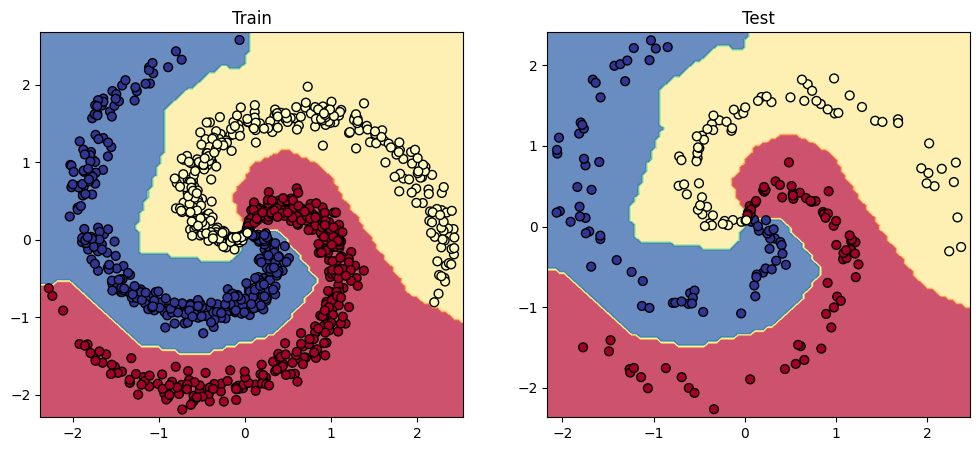

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_decision_boundary_numpy(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Define axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Generate grid points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make predictions for the entire grid
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Save figure if filepath provided
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")

# Visualize the decision boundary
plt.figure(figsize=(12,5))

# Train set decision boundary
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary_numpy(model=model, X=X_train, y=y_train)

# Test set decision boundary
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary_numpy(model=model, X=X_test, y=y_test)

# Display plots
plt.show()


# **PyTorch**
Now let's implement the same MLP in PyTorch.



# **Model**
We'll be using two linear layers along with PyTorch Functional API's ReLU operation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # Output layer

    def forward(self, x_in):
        """Forward pass through the network."""
        z = F.relu(self.fc1(x_in))  # Apply ReLU activation
        z = self.fc2(z)  # Output layer (logits)
        return z

# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)

# Print model parameters
print(model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# **Training**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Loss Function with Class Weights
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Accuracy Function
def accuracy_fn(y_pred, y_true):
    """Compute accuracy by comparing predictions with true labels."""
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

# Training Loop
for epoch in range(NUM_EPOCHS * 10):
    # Forward pass
    y_pred = model(X_train)

    # Compute Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass (compute gradients)
    loss.backward()

    # Update weights
    optimizer.step()

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        predictions = y_pred.max(dim=1)[1]  # Get predicted class labels
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {accuracy:.1f}")


Epoch: 0 | Loss: 1.10, Accuracy: 45.7
Epoch: 10 | Loss: 0.67, Accuracy: 57.8
Epoch: 20 | Loss: 0.52, Accuracy: 73.0
Epoch: 30 | Loss: 0.40, Accuracy: 85.3
Epoch: 40 | Loss: 0.30, Accuracy: 89.0
Epoch: 50 | Loss: 0.23, Accuracy: 92.3
Epoch: 60 | Loss: 0.19, Accuracy: 94.6
Epoch: 70 | Loss: 0.16, Accuracy: 96.3
Epoch: 80 | Loss: 0.13, Accuracy: 97.2
Epoch: 90 | Loss: 0.11, Accuracy: 97.8


# **Evaluation **

In [ ]:
import json
import torch.nn.functional as F

# Generate Predictions
y_prob = F.softmax(model(X_test), dim=1)  # Apply softmax to get class probabilities
y_pred = y_prob.max(dim=1)[1]  # Get the predicted class labels

# Evaluate Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)

# Print Performance Metrics in JSON Format
print(json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9784927332395688,
    "recall": 0.9777777777777777,
    "f1": 0.9777669863959414,
    "num_samples": 225
  },
  "class": {
    "0": {
      "precision": 0.9861111111111112,
      "recall": 0.9466666666666667,
      "f1": 0.9659863945578231,
      "num_samples": 75
    },
    "1": {
      "precision": 0.9493670886075949,
      "recall": 1.0,
      "f1": 0.974025974025974,
      "num_samples": 75
    },
    "2": {
      "precision": 1.0,
      "recall": 0.9866666666666667,
      "f1": 0.9932885906040269,
      "num_samples": 75
    }
  }
}


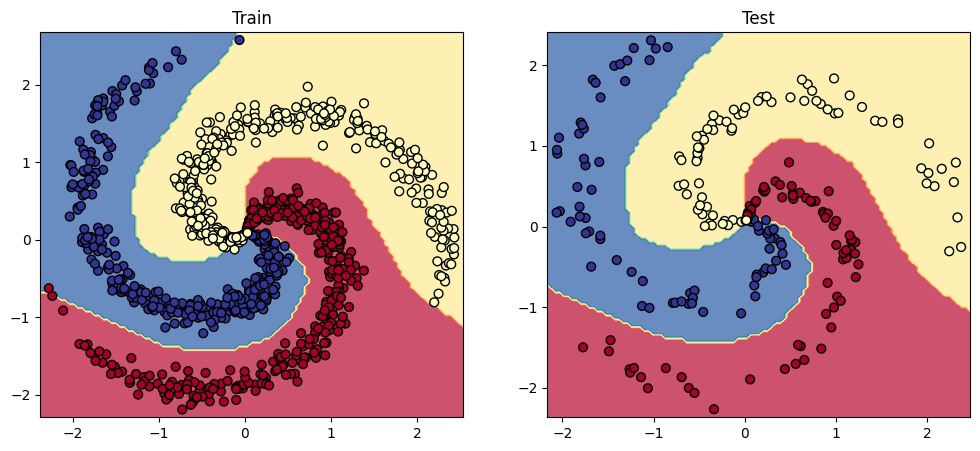

In [ ]:
import matplotlib.pyplot as plt

# Visualize the decision boundary
plt.figure(figsize=(12, 5))

# Plot decision boundary for training data
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train.numpy(), y=y_train.numpy())

# Plot decision boundary for test data
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test.numpy(), y=y_test.numpy())

# Show plots
plt.show()


Inference
Let's look at the inference operations when using our trained model.

In [ ]:
import pandas as pd

# Inputs for inference
X_infer = pd.DataFrame([{"X1": 0.1, "X2": 0.1}])

# Standardize input using the previously fitted scaler
X_infer = X_scaler.transform(X_infer)

# Print the standardized input
print(X_infer)


[[0.2707413  0.33639042]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
import torch
import torch.nn.functional as F

# Convert standardized input to a PyTorch tensor
y_infer = F.softmax(model(torch.Tensor(X_infer)), dim=1)

# Get the predicted class and probability
prob, _class = y_infer.max(dim=1)

# Convert class index back to label
label = label_encoder.inverse_transform(_class.detach().numpy())[0]

# Print the inference result
print(f"The probability that you have {label} is {prob.detach().numpy()[0] * 100.0:.0f}%")


The probability that you have 0 is 94%


# **Initializing weights**
So far we have been initializing weights with small random values but this isn't optimal for convergence during training. The objective is to initialize the appropriate weights such that our activations (outputs of layers) don't vanish (too small) or explode (too large), as either of these situations will hinder convergence. We can do this by sampling the weights uniformly from a bound distribution (many that take into account the precise activation function used) such that all activations have unit variance.

In [ ]:
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # Output layer

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize weights using Xavier initialization with gain for ReLU."""
        init.xavier_normal_(self.fc1.weight, gain=init.calculate_gain("relu"))
        init.xavier_normal_(self.fc2.weight)  # Default gain for output layer

    def forward(self, x_in):
        """Forward pass through the network."""
        z = F.relu(self.fc1(x_in))  # Apply ReLU activation
        z = self.fc2(z)  # Output layer (logits)
        return z


# **Dropout**
A great technique to have our models generalize (perform well on test data) is to increase the size of your data but this isn't always an option. Fortunately, there are methods like regularization and dropout that can help create a more robust model.

Dropout is a technique (used only during training) that allows us to zero the outputs of neurons. We do this for dropout_p% of the total neurons in each layer and it changes every batch. Dropout prevents units from co-adapting too much to the data and acts as a sampling strategy since we drop a different set of neurons each time.



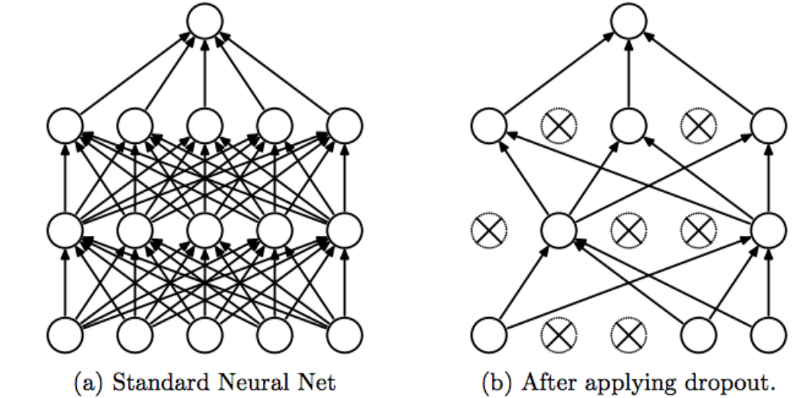

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

DROPOUT_P = 0.1  # Percentage of neurons dropped during training

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.dropout = nn.Dropout(dropout_p)  # Dropout layer to prevent overfitting
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # Output layer

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize weights using Xavier initialization for better convergence."""
        init.xavier_normal_(self.fc1.weight, gain=init.calculate_gain("relu"))
        init.xavier_normal_(self.fc2.weight)  # Default gain for output layer

    def forward(self, x_in):
        """Forward pass through the network."""
        z = F.relu(self.fc1(x_in))  # Apply ReLU activation
        z = self.dropout(z)  # Apply dropout during training
        z = self.fc2(z)  # Output layer (logits)
        return z

# Initialize model with dropout
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)

# Print model parameters
print(model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


Overfitting
Though neural networks are great at capturing non-linear relationships they are highly susceptible to overfitting to the training data and failing to generalize on test data. Just take a look at the example below where we generate completely random data and are able to fit a model with 2∗N∗C+D (where N = # of samples, C = # of classes and D = input dimension) hidden units. The training performance is good (~70%) but the overfitting leads to very poor test performance. We'll be covering strategies to tackle overfitting in future lessons.

In [ ]:
import numpy as np

# Define training parameters
NUM_EPOCHS = 500
NUM_SAMPLES_PER_CLASS = 50
LEARNING_RATE = 1e-1

# Compute hidden layer size using the formula: 2 * N * C + D
HIDDEN_DIM = 2 * NUM_SAMPLES_PER_CLASS * NUM_CLASSES + INPUT_DIM  # (2 * 50 * 3) + 2

# Generate random dataset
X = np.random.rand(NUM_SAMPLES_PER_CLASS * NUM_CLASSES, INPUT_DIM)
y = np.array([[i] * NUM_SAMPLES_PER_CLASS for i in range(NUM_CLASSES)]).reshape(-1)

# Print dataset shapes
print("X shape:", X.shape)  # Expected: (150, 2)
print("y shape:", y.shape)  # Expected: (150,)


X shape: (150, 2)
y shape: (150,)


In [ ]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE
)

# Print dataset shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Print a sample point
print(f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (105, 2), y_train: (105,)
X_val: (22, 2), y_val: (22,)
X_test: (23, 2), y_test: (23,)
Sample point: [0.97931737 0.89742329] → 2


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch

# Standardize the inputs (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

# Apply standardization to train, validation, and test sets
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

# Initialize model with dropout
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)

# Print model parameters
print(model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=302, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=302, out_features=3, bias=True)
)>


In [ ]:
from torch.optim import Adam

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Compute loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass (compute gradients)
    loss.backward()

    # Update weights
    optimizer.step()

    # Print progress every 20 epochs
    if epoch % 20 == 0:
        predictions = y_pred.max(dim=1)[1]  # Get predicted class labels
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {accuracy:.1f}")


Epoch: 0 | Loss: 1.33, Accuracy: 33.3
Epoch: 20 | Loss: 1.01, Accuracy: 48.6
Epoch: 40 | Loss: 0.89, Accuracy: 57.1
Epoch: 60 | Loss: 0.85, Accuracy: 58.1
Epoch: 80 | Loss: 0.80, Accuracy: 61.9
Epoch: 100 | Loss: 0.82, Accuracy: 61.9
Epoch: 120 | Loss: 0.89, Accuracy: 59.0
Epoch: 140 | Loss: 0.81, Accuracy: 57.1
Epoch: 160 | Loss: 0.75, Accuracy: 70.5
Epoch: 180 | Loss: 0.88, Accuracy: 62.9
Epoch: 200 | Loss: 0.83, Accuracy: 66.7
Epoch: 220 | Loss: 0.82, Accuracy: 61.9
Epoch: 240 | Loss: 0.83, Accuracy: 65.7
Epoch: 260 | Loss: 0.73, Accuracy: 64.8
Epoch: 280 | Loss: 0.77, Accuracy: 63.8
Epoch: 300 | Loss: 0.72, Accuracy: 68.6
Epoch: 320 | Loss: 0.76, Accuracy: 69.5
Epoch: 340 | Loss: 0.88, Accuracy: 59.0
Epoch: 360 | Loss: 0.74, Accuracy: 70.5
Epoch: 380 | Loss: 0.79, Accuracy: 60.0
Epoch: 400 | Loss: 0.76, Accuracy: 63.8
Epoch: 420 | Loss: 0.80, Accuracy: 68.6
Epoch: 440 | Loss: 0.76, Accuracy: 64.8
Epoch: 460 | Loss: 0.80, Accuracy: 69.5
Epoch: 480 | Loss: 0.78, Accuracy: 64.8


In [ ]:
import json
import torch.nn.functional as F

# Generate predictions
y_prob = F.softmax(model(X_test), dim=1)  # Apply softmax to get class probabilities
y_pred = y_prob.max(dim=1)[1]  # Get the predicted class labels

# Evaluate model performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)

# Print performance metrics in JSON format
print(json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.18181818181818182,
    "recall": 0.21739130434782608,
    "f1": 0.19679633867276888,
    "num_samples": 23
  },
  "class": {
    "0": {
      "precision": 0.0,
      "recall": 0.0,
      "f1": 0.0,
      "num_samples": 7
    },
    "1": {
      "precision": 0.2727272727272727,
      "recall": 0.375,
      "f1": 0.3157894736842105,
      "num_samples": 8
    },
    "2": {
      "precision": 0.25,
      "recall": 0.25,
      "f1": 0.25,
      "num_samples": 8
    }
  }
}


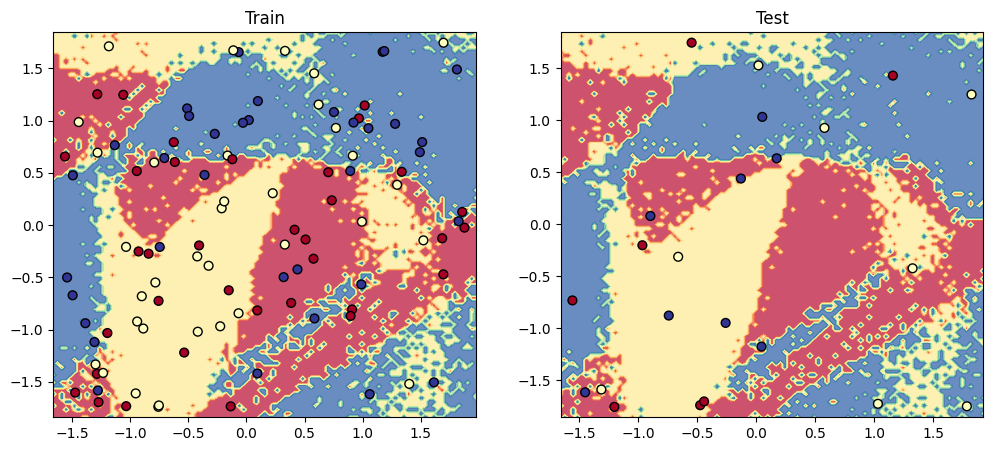

In [ ]:
import matplotlib.pyplot as plt

# Visualize the decision boundary
plt.figure(figsize=(12, 5))

# Plot decision boundary for training data
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train.numpy(), y=y_train.numpy())

# Plot decision boundary for test data
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test.numpy(), y=y_test.numpy())

# Display plots
plt.show()
